In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

from keras.models import Sequential
from keras.layers import Dense

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
df = pd.read_excel('Dataset.xlsx')

## Clean Data

In [3]:
# Get the list of columns to convert to categorical
categorical_columns = df.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df[categorical_columns] = df[categorical_columns].astype('category')

numeric_data = df.select_dtypes(include=[np.number])

# Calculate MAD for each column
mad = numeric_data.mad()

# Choose a threshold multiplier
k = 3

# Calculate the threshold value
threshold = k * mad

# Identify outliers
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Apply logarithm to the specified columns
outlier_columns = ['CommissionSacrificePercentage', 'BonusCommissionPercentage']
for column in outlier_columns:
    df[column] = np.log1p(df[column])

In [4]:
df = df.drop(columns=['PropDate'])

# All Features

## Logistic Regression

In [43]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes to iterate over
test_sizes = [0.2, 0.3]

for test_size in test_sizes:
    print(f"Test Size: {test_size}")
    
    # Split the data using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Initialise and train logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    confusion_mat = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Confusion Matrix:\n", confusion_mat)
    print("\nClassification Report:\n", class_report)
    print("---------------------------------------------")


Test Size: 0.2
Confusion Matrix:
 [[  540  6432]
 [  440 24041]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.08      0.14      6972
           1       0.79      0.98      0.87     24481

    accuracy                           0.78     31453
   macro avg       0.67      0.53      0.51     31453
weighted avg       0.74      0.78      0.71     31453

---------------------------------------------
Test Size: 0.3
Confusion Matrix:
 [[ 1153  9305]
 [  993 35728]]

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.11      0.18     10458
           1       0.79      0.97      0.87     36721

    accuracy                           0.78     47179
   macro avg       0.67      0.54      0.53     47179
weighted avg       0.74      0.78      0.72     47179

---------------------------------------------


Test Size: 0.2
Training AUC: 0.5316901895220901
Test AUC: 0.529739772900562
Training Accuracy: 0.7827517685398617
Test Accuracy: 0.781515276762153
Test Size: 0.3
Training AUC: 0.5452281212192144
Test AUC: 0.5416043893420354
Training Accuracy: 0.7840194760364813
Test Accuracy: 0.7817249199855868
   Test Size  Train AUC  Test AUC  Train Accuracy  Test Accuracy
0        0.2   0.531690  0.529740        0.782752       0.781515
1        0.3   0.545228  0.541604        0.784019       0.781725


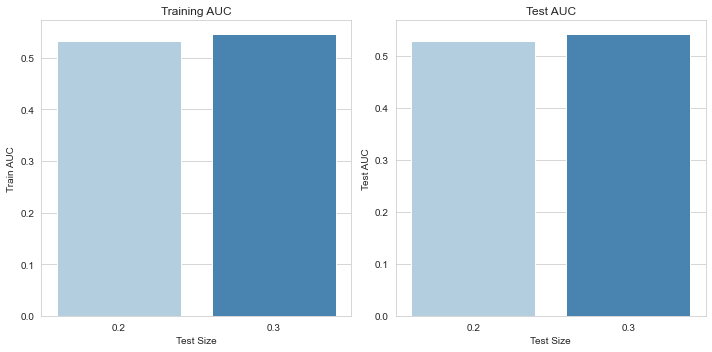

In [49]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes to iterate over
test_sizes = [0.2, 0.3]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    print(f"Test Size: {test_size}")

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Initialise logistic regression model
    model = LogisticRegression()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calculate AUC and accuracy for test and training data
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print metrics for training and test data
    print("Training AUC:", train_auc)
    print("Test AUC:", test_auc)
    print("Training Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("=============================================")

    # Store results in a dictionary
    result = {
        'Test Size': test_size,
        'Train AUC': train_auc,
        'Test AUC': test_auc,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
    }

    results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create bar plots for AUC and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Test Size', y='Train AUC', palette="Blues")
plt.title("Training AUC")

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Test Size', y='Test AUC', palette="Blues")
plt.title("Test AUC")

plt.tight_layout()
plt.show()


#### Experiment with different test sizes, and number of folds for Cross-Validation

Test Size: 0.2, Number of Folds: 5
Average Training AUC: 0.5423679853466515
Average Training Accuracy: 0.7836956521739131
Average Test AUC: 0.5420776766552364
Average Test Accuracy: 0.7836896908035926
Test Size: 0.2, Number of Folds: 10
Average Training AUC: 0.5430108046826247
Average Training Accuracy: 0.7837391480981021
Average Test AUC: 0.5429259153852103
Average Test Accuracy: 0.7835943088784676
Test Size: 0.2, Number of Folds: 20
Average Training AUC: 0.5419083669937221
Average Training Accuracy: 0.7834328291448187
Average Test AUC: 0.5417648399424666
Average Test Accuracy: 0.7832446508614145
Test Size: 0.3, Number of Folds: 5
Average Training AUC: 0.5476965495532664
Average Training Accuracy: 0.7838264431227308
Average Test AUC: 0.5473723794058134
Average Test Accuracy: 0.7836107080245075
Test Size: 0.3, Number of Folds: 10
Average Training AUC: 0.5455065586226334
Average Training Accuracy: 0.7839690100342456
Average Test AUC: 0.5454685889225945
Average Test Accuracy: 0.784046714

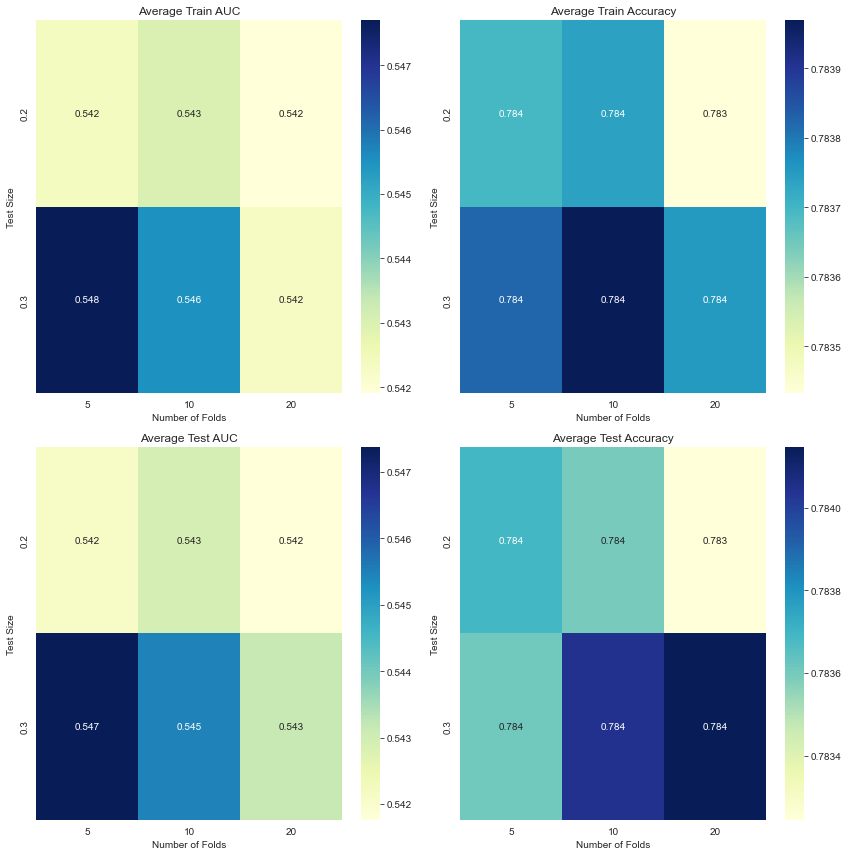

In [45]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes and numbers of folds to iterate over
test_sizes = [0.2, 0.3]
num_folds_list = [5, 10, 20]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    for num_folds in num_folds_list:
        print(f"Test Size: {test_size}, Number of Folds: {num_folds}")

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        # Initialise logistic regression model
        model = LogisticRegression()

        # Initialise KFold with current number of folds
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

        # Lists to store evaluation metrics for training and test data
        train_auc_scores = []
        train_accuracy_scores = []
        test_auc_scores = []
        test_accuracy_scores = []

        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X_train):
            X_fold_train, y_fold_train = X_train.iloc[train_index], y_train.iloc[train_index]
            X_fold_test, y_fold_test = X_train.iloc[test_index], y_train.iloc[test_index]

            # Fit the model to the training fold data
            model.fit(X_fold_train, y_fold_train)

            # Predict on the fold test data using the trained model
            y_fold_test_pred = model.predict(X_fold_test)
            y_fold_train_pred = model.predict(X_fold_train)

            train_auc = roc_auc_score(y_fold_train, y_fold_train_pred)
            train_accuracy = accuracy_score(y_fold_train, y_fold_train_pred)
            test_auc = roc_auc_score(y_fold_test, y_fold_test_pred)
            test_accuracy = accuracy_score(y_fold_test, y_fold_test_pred)

            train_auc_scores.append(train_auc)
            train_accuracy_scores.append(train_accuracy)
            test_auc_scores.append(test_auc)
            test_accuracy_scores.append(test_accuracy)

        # Fit the model to the entire training data
        model.fit(X_train, y_train)

        # Evaluate the model on the separate test data
        y_test_pred = model.predict(X_test)
        test_auc = roc_auc_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate average AUC and accuracy across all folds for training and test data
        train_avg_auc = sum(train_auc_scores) / num_folds
        train_avg_accuracy = sum(train_accuracy_scores) / num_folds
        test_avg_auc = sum(test_auc_scores) / num_folds
        test_avg_accuracy = sum(test_accuracy_scores) / num_folds

        # Print average metrics for training and test data
        print("Average Training AUC:", train_avg_auc)
        print("Average Training Accuracy:", train_avg_accuracy)
        print("Average Test AUC:", test_avg_auc)
        print("Average Test Accuracy:", test_avg_accuracy)
        print("=============================================")

        # Store results in a dictionary
        result = {
            'Test Size': test_size,
            'Number of Folds': num_folds,
            'Train AUC': train_avg_auc,
            'Train Accuracy': train_avg_accuracy,
            'Test AUC': test_avg_auc,
            'Test Accuracy': test_avg_accuracy,
        }

        results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create heatmaps for average AUC and accuracy
heatmap_data_train_auc = results_df.pivot("Test Size", "Number of Folds", "Train AUC")
heatmap_data_train_accuracy = results_df.pivot("Test Size", "Number of Folds", "Train Accuracy")
heatmap_data_test_auc = results_df.pivot("Test Size", "Number of Folds", "Test AUC")
heatmap_data_test_accuracy = results_df.pivot("Test Size", "Number of Folds", "Test Accuracy")

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(heatmap_data_train_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train AUC")

plt.subplot(2, 2, 2)
sns.heatmap(heatmap_data_train_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train Accuracy")

plt.subplot(2, 2, 3)
sns.heatmap(heatmap_data_test_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test AUC")

plt.subplot(2, 2, 4)
sns.heatmap(heatmap_data_test_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test Accuracy")

plt.tight_layout()
plt.show()


### Stochastic Gradient Descent

Test Size: 0.2
Training AUC: 0.664638426534951
Test AUC: 0.664033180227138
Training Accuracy: 0.5223670614418567
Test Accuracy: 0.5200457825962548
Test Size: 0.3
Training AUC: 0.5075602678577109
Test AUC: 0.5075138007176337
Training Accuracy: 0.7737909232949384
Test Accuracy: 0.7743275609911189
   Test Size  Train AUC  Test AUC  Train Accuracy  Test Accuracy
0        0.2   0.664638  0.664033        0.522367       0.520046
1        0.3   0.507560  0.507514        0.773791       0.774328


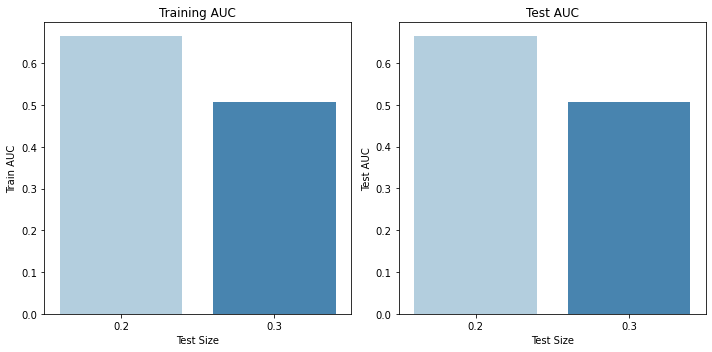

In [11]:

from sklearn.linear_model import SGDClassifier

# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes to iterate over
test_sizes = [0.2, 0.3]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    print(f"Test Size: {test_size}")

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Initialise SGD classifier model
    model = SGDClassifier(loss='log', random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calculate AUC and accuracy for test and training data
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print metrics for training and test data
    print("Training AUC:", train_auc)
    print("Test AUC:", test_auc)
    print("Training Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("=============================================")

    # Store results in a dictionary
    result = {
        'Test Size': test_size,
        'Train AUC': train_auc,
        'Test AUC': test_auc,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
    }

    results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create bar plots for AUC and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Test Size', y='Train AUC', palette="Blues")
plt.title("Training AUC")

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Test Size', y='Test AUC', palette="Blues")
plt.title("Test AUC")

plt.tight_layout()
plt.show()


#### Cross Validation

Test Size: 0.2, Number of Folds: 5
Average Training AUC: 0.548872725009004
Average Training Accuracy: 0.767166759399094
Average Test AUC: 0.5483204136314083
Average Test Accuracy: 0.7665209442810588
Test Size: 0.2, Number of Folds: 10
Average Training AUC: 0.6219340775934707
Average Training Accuracy: 0.7193095408420105
Average Test AUC: 0.6207539036817689
Average Test Accuracy: 0.7187187028058182
Test Size: 0.2, Number of Folds: 20
Average Training AUC: 0.588713535440917
Average Training Accuracy: 0.7298090416508078
Average Test AUC: 0.5883905595785599
Average Test Accuracy: 0.7318794684611398
Test Size: 0.3, Number of Folds: 5
Average Training AUC: 0.6111031848203203
Average Training Accuracy: 0.6684052537617478
Average Test AUC: 0.6109025039353518
Average Test Accuracy: 0.6689628405369371
Test Size: 0.3, Number of Folds: 10
Average Training AUC: 0.5559722398365242
Average Training Accuracy: 0.7703905038701941
Average Test AUC: 0.5552580840844744
Average Test Accuracy: 0.770420697184

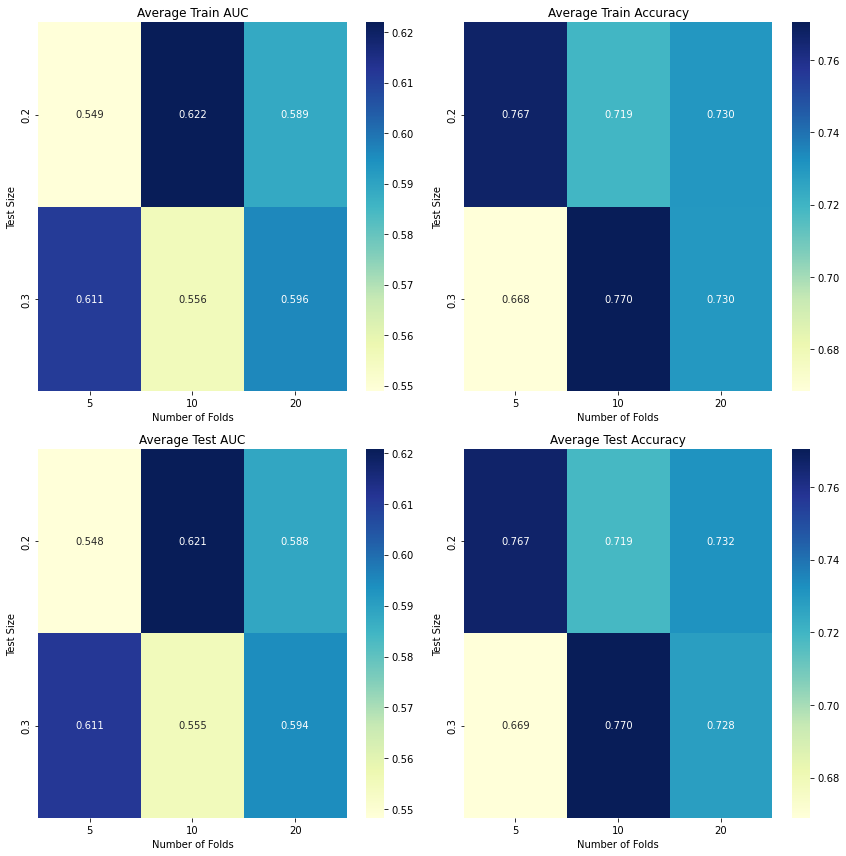

In [12]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes and numbers of folds to iterate over
test_sizes = [0.2, 0.3]
num_folds_list = [5, 10, 20]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    for num_folds in num_folds_list:
        print(f"Test Size: {test_size}, Number of Folds: {num_folds}")

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        # Initialise SGD classifier model
        model = SGDClassifier(loss='log', random_state=42)

        # Initialise KFold with current number of folds
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

        # Lists to store evaluation metrics for training and test data
        train_auc_scores = []
        train_accuracy_scores = []
        test_auc_scores = []
        test_accuracy_scores = []

        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X_train):
            X_fold_train, y_fold_train = X_train.iloc[train_index], y_train.iloc[train_index]
            X_fold_test, y_fold_test = X_train.iloc[test_index], y_train.iloc[test_index]

            # Fit the model to the training fold data
            model.fit(X_fold_train, y_fold_train)

            # Predict on the fold test data using the trained model
            y_fold_test_pred = model.predict(X_fold_test)
            y_fold_train_pred = model.predict(X_fold_train)

            train_auc = roc_auc_score(y_fold_train, y_fold_train_pred)
            train_accuracy = accuracy_score(y_fold_train, y_fold_train_pred)
            test_auc = roc_auc_score(y_fold_test, y_fold_test_pred)
            test_accuracy = accuracy_score(y_fold_test, y_fold_test_pred)

            train_auc_scores.append(train_auc)
            train_accuracy_scores.append(train_accuracy)
            test_auc_scores.append(test_auc)
            test_accuracy_scores.append(test_accuracy)

        # Fit the model to the entire training data
        model.fit(X_train, y_train)

        # Evaluate the model on the separate test data
        y_test_pred = model.predict(X_test)
        test_auc = roc_auc_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate average AUC and accuracy across all folds for training and test data
        train_avg_auc = sum(train_auc_scores) / num_folds
        train_avg_accuracy = sum(train_accuracy_scores) / num_folds
        test_avg_auc = sum(test_auc_scores) / num_folds
        test_avg_accuracy = sum(test_accuracy_scores) / num_folds

        # Print average metrics for training and test data
        print("Average Training AUC:", train_avg_auc)
        print("Average Training Accuracy:", train_avg_accuracy)
        print("Average Test AUC:", test_avg_auc)
        print("Average Test Accuracy:", test_avg_accuracy)
        print("=============================================")

        # Store results in a dictionary
        result = {
            'Test Size': test_size,
            'Number of Folds': num_folds,
            'Train AUC': train_avg_auc,
            'Train Accuracy': train_avg_accuracy,
            'Test AUC': test_avg_auc,
            'Test Accuracy': test_avg_accuracy,
        }

        results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create heatmaps for average AUC and accuracy
heatmap_data_train_auc = results_df.pivot("Test Size", "Number of Folds", "Train AUC")
heatmap_data_train_accuracy = results_df.pivot("Test Size", "Number of Folds", "Train Accuracy")
heatmap_data_test_auc = results_df.pivot("Test Size", "Number of Folds", "Test AUC")
heatmap_data_test_accuracy = results_df.pivot("Test Size", "Number of Folds", "Test Accuracy")

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(heatmap_data_train_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train AUC")

plt.subplot(2, 2, 2)
sns.heatmap(heatmap_data_train_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train Accuracy")

plt.subplot(2, 2, 3)
sns.heatmap(heatmap_data_test_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test AUC")

plt.subplot(2, 2, 4)
sns.heatmap(heatmap_data_test_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test Accuracy")

plt.tight_layout()
plt.show()


### Decision Tree

Test Size: 0.2
Training AUC: 0.8281823504851936
Test AUC: 0.6621094161493699
Training Accuracy: 0.8866942214450362
Test Accuracy: 0.7720726162846151
Test Size: 0.3
Training AUC: 0.8373331675336475
Test AUC: 0.6597014154829633
Training Accuracy: 0.8899749282366193
Test Accuracy: 0.7684563047118421
   Test Size  Train AUC  Test AUC  Train Accuracy  Test Accuracy
0        0.2   0.828182  0.662109        0.886694       0.772073
1        0.3   0.837333  0.659701        0.889975       0.768456


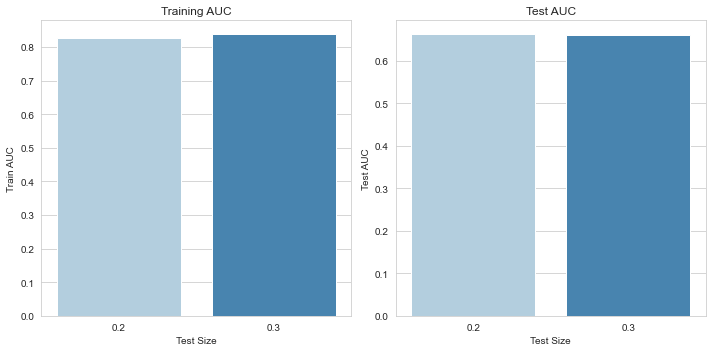

In [48]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes to iterate over
test_sizes = [0.2, 0.3]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    print(f"Test Size: {test_size}")

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Initialise decision tree classifier model
    model = DecisionTreeClassifier()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calculate AUC and accuracy for test and training data
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print metrics for training and test data
    print("Training AUC:", train_auc)
    print("Test AUC:", test_auc)
    print("Training Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("=============================================")

    # Store results in a dictionary
    result = {
        'Test Size': test_size,
        'Train AUC': train_auc,
        'Test AUC': test_auc,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
    }

    results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create bar plots for AUC and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Test Size', y='Train AUC', palette="Blues")
plt.title("Training AUC")

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Test Size', y='Test AUC', palette="Blues")
plt.title("Test AUC")

plt.tight_layout()
plt.show()


#### Cross Validation

Test Size: 0.2, Number of Folds: 5
Average Training AUC: 0.8382339661534722
Average Training Accuracy: 0.8915447897623402
Average Test AUC: 0.6559458341015934
Average Test Accuracy: 0.7631269374453542
Test Size: 0.2, Number of Folds: 10
Average Training AUC: 0.8335396135865032
Average Training Accuracy: 0.888935696685478
Average Test AUC: 0.6579171846947711
Average Test Accuracy: 0.7658294253239012
Test Size: 0.2, Number of Folds: 20
Average Training AUC: 0.8311341270123969
Average Training Accuracy: 0.8877697778958771
Average Test AUC: 0.6581923243360748
Average Test Accuracy: 0.7669023302524944
Test Size: 0.3, Number of Folds: 5
Average Training AUC: 0.8456953025905862
Average Training Accuracy: 0.8949279639329382
Average Test AUC: 0.6589723213318338
Average Test Accuracy: 0.7640074685285472
Test Size: 0.3, Number of Folds: 10
Average Training AUC: 0.8411234944041018
Average Training Accuracy: 0.8922994163471435
Average Test AUC: 0.6583149028974475
Average Test Accuracy: 0.7645706969

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

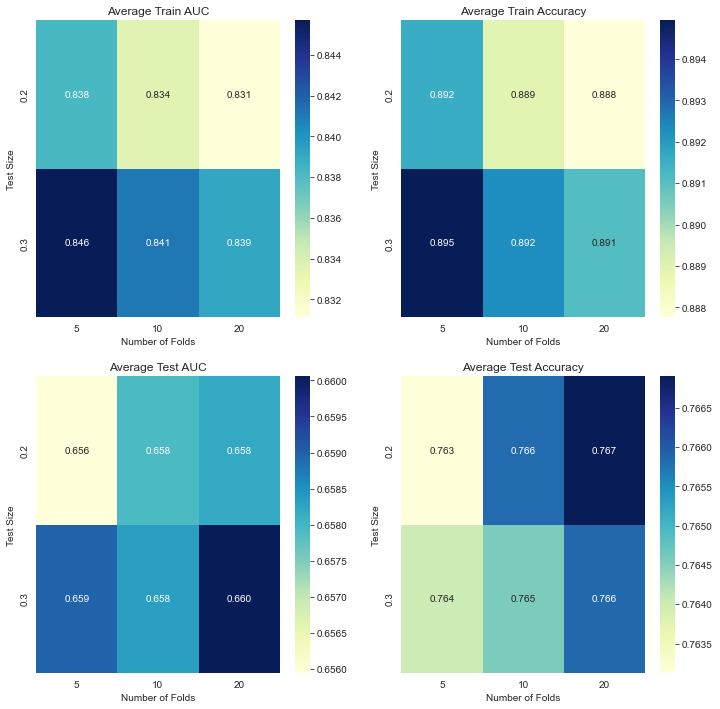

In [46]:

# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes and numbers of folds to iterate over
test_sizes = [0.2, 0.3]
num_folds_list = [5, 10, 20]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    for num_folds in num_folds_list:
        print(f"Test Size: {test_size}, Number of Folds: {num_folds}")

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        # Initialise decision tree classifier model
        model = DecisionTreeClassifier()

        # Initialise KFold with current number of folds
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

        # Lists to store evaluation metrics for training and test data
        train_auc_scores = []
        train_accuracy_scores = []
        test_auc_scores = []
        test_accuracy_scores = []

        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X_train):
            X_fold_train, y_fold_train = X_train.iloc[train_index], y_train.iloc[train_index]
            X_fold_test, y_fold_test = X_train.iloc[test_index], y_train.iloc[test_index]

            # Fit the model to the training fold data
            model.fit(X_fold_train, y_fold_train)

            # Predict on the fold test data using the trained model
            y_fold_test_pred = model.predict(X_fold_test)
            y_fold_train_pred = model.predict(X_fold_train)

            train_auc = roc_auc_score(y_fold_train, y_fold_train_pred)
            train_accuracy = accuracy_score(y_fold_train, y_fold_train_pred)
            test_auc = roc_auc_score(y_fold_test, y_fold_test_pred)
            test_accuracy = accuracy_score(y_fold_test, y_fold_test_pred)

            train_auc_scores.append(train_auc)
            train_accuracy_scores.append(train_accuracy)
            test_auc_scores.append(test_auc)
            test_accuracy_scores.append(test_accuracy)

        # Fit the model to the entire training data
        model.fit(X_train, y_train)

        # Evaluate the model on the separate test data
        y_test_pred = model.predict(X_test)
        test_auc = roc_auc_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate average AUC and accuracy across all folds for training and test data
        train_avg_auc = sum(train_auc_scores) / num_folds
        train_avg_accuracy = sum(train_accuracy_scores) / num_folds
        test_avg_auc = sum(test_auc_scores) / num_folds
        test_avg_accuracy = sum(test_accuracy_scores) / num_folds

        # Print average metrics for training and test data
        print("Average Training AUC:", train_avg_auc)
        print("Average Training Accuracy:", train_avg_accuracy)
        print("Average Test AUC:", test_avg_auc)
        print("Average Test Accuracy:", test_avg_accuracy)
        print("=============================================")

        # Store results in a dictionary
        result = {
            'Test Size': test_size,
            'Number of Folds': num_folds,
            'Train AUC': train_avg_auc,
            'Train Accuracy': train_avg_accuracy,
            'Test AUC': test_avg_auc,
            'Test Accuracy': test_avg_accuracy,
        }

        results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create heatmaps for average AUC and accuracy
heatmap_data_train_auc = results_df.pivot("Test Size", "Number of Folds", "Train AUC")
heatmap_data_train_accuracy = results_df.pivot("Test Size", "Number of Folds", "Train Accuracy")
heatmap_data_test_auc = results_df.pivot("Test Size", "Number of Folds", "Test AUC")
heatmap_data_test_accuracy = results_df.pivot("Test Size", "Number of Folds", "Test Accuracy")

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(heatmap_data_train_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train AUC")

plt.subplot(2, 2, 2)
sns.heatmap(heatmap_data_train_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train Accuracy")

plt.subplot(2, 2, 3)
sns.heatmap(heatmap_data_test_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test AUC")

plt.subplot(2, 2, 4)
sns.heatmap(heatmap_data_test_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test Accuracy")

plt.tight_layout


### Random Forest

Test Size: 0.2
Training AUC: 0.8073300578446978
Test AUC: 0.6549428792331206
Training Accuracy: 0.8866703759637549
Test Accuracy: 0.784790004133151
Test Size: 0.3
Training AUC: 0.8142786417230734
Test AUC: 0.6516803213143051
Training Accuracy: 0.8899476763199011
Test Accuracy: 0.7823184043748278
   Test Size  Train AUC  Test AUC  Train Accuracy  Test Accuracy
0        0.2   0.807330  0.654943        0.886670       0.784790
1        0.3   0.814279  0.651680        0.889948       0.782318


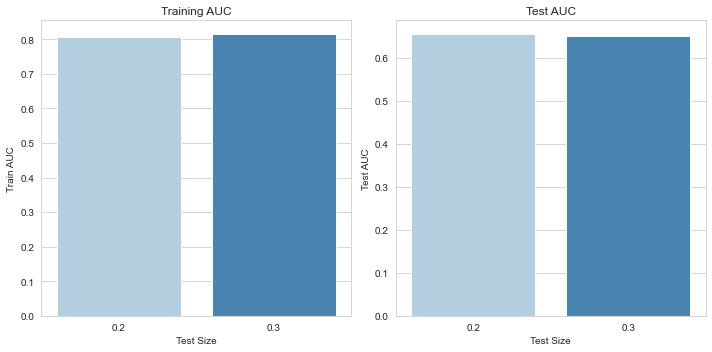

In [52]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes to iterate over
test_sizes = [0.2, 0.3]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    print(f"Test Size: {test_size}")

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Initialise Random Forest classifier model
    model = RandomForestClassifier()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calculate AUC and accuracy for test and training data
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print metrics for training and test data
    print("Training AUC:", train_auc)
    print("Test AUC:", test_auc)
    print("Training Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("=============================================")

    # Store results in a dictionary
    result = {
        'Test Size': test_size,
        'Train AUC': train_auc,
        'Test AUC': test_auc,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
    }

    results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create bar plots for AUC and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Test Size', y='Train AUC', palette="Blues")
plt.title("Training AUC")

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Test Size', y='Test AUC', palette="Blues")
plt.title("Test AUC")

plt.tight_layout()
plt.show()


#### Cross Validation

Test Size: 0.2, Number of Folds: 5
Average Training AUC: 0.8163856121237304
Average Training Accuracy: 0.8915070344169781
Average Test AUC: 0.6456089053843472
Average Test Accuracy: 0.7766552738256101
Test Size: 0.2, Number of Folds: 10
Average Training AUC: 0.8119818317168935
Average Training Accuracy: 0.8889012532125162
Average Test AUC: 0.6476366139280864
Average Test Accuracy: 0.7780303632461649
Test Size: 0.2, Number of Folds: 20
Average Training AUC: 0.809711125369647
Average Training Accuracy: 0.8877363105362264
Average Test AUC: 0.6492303670571908
Average Test Accuracy: 0.779453094851984
Test Size: 0.3, Number of Folds: 5
Average Training AUC: 0.8232277892831743
Average Training Accuracy: 0.8948916280388225
Average Test AUC: 0.646913849479343
Average Test Accuracy: 0.7766341816933744
Test Size: 0.3, Number of Folds: 10
Average Training AUC: 0.8189221224264231
Average Training Accuracy: 0.892250968507424
Average Test AUC: 0.6483424741889258
Average Test Accuracy: 0.7780150171463

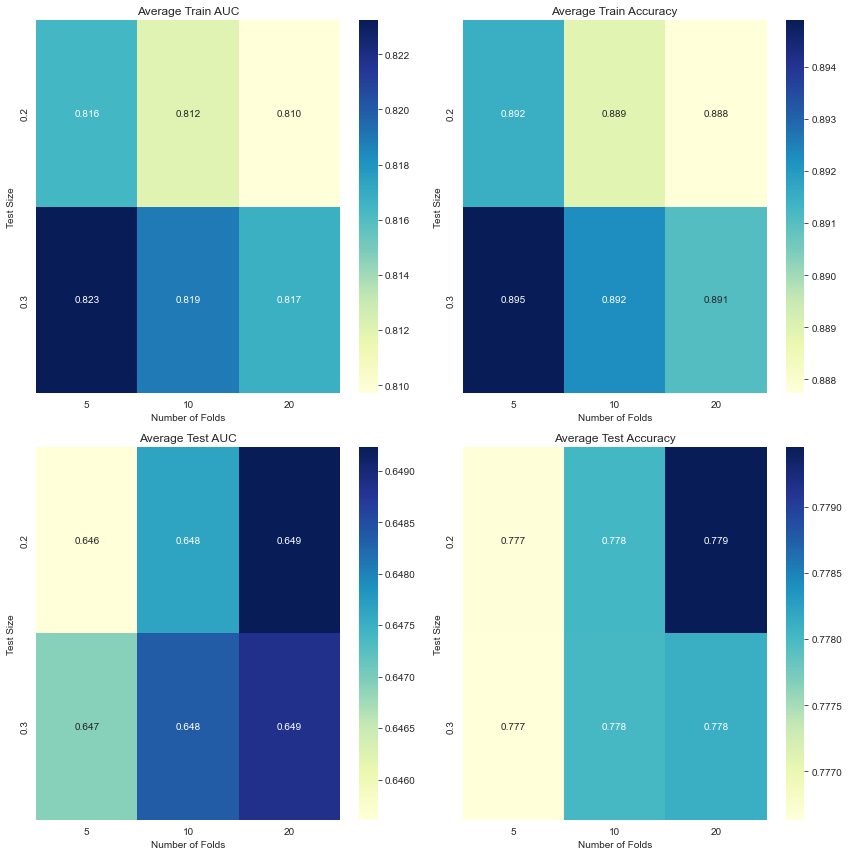

In [54]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes and numbers of folds to iterate over
test_sizes = [0.2, 0.3]
num_folds_list = [5, 10, 20]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    for num_folds in num_folds_list:
        print(f"Test Size: {test_size}, Number of Folds: {num_folds}")

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        # Initialise Random Forest classifier model
        model = RandomForestClassifier()

        # Initialise KFold with current number of folds
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

        # Lists to store evaluation metrics for training and test data
        train_auc_scores = []
        train_accuracy_scores = []
        test_auc_scores = []
        test_accuracy_scores = []

        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X_train):
            X_fold_train, y_fold_train = X_train.iloc[train_index], y_train.iloc[train_index]
            X_fold_test, y_fold_test = X_train.iloc[test_index], y_train.iloc[test_index]

            # Fit the model to the training fold data
            model.fit(X_fold_train, y_fold_train)

            # Predict on the fold test data using the trained model
            y_fold_test_pred = model.predict(X_fold_test)
            y_fold_train_pred = model.predict(X_fold_train)

            train_auc = roc_auc_score(y_fold_train, y_fold_train_pred)
            train_accuracy = accuracy_score(y_fold_train, y_fold_train_pred)
            test_auc = roc_auc_score(y_fold_test, y_fold_test_pred)
            test_accuracy = accuracy_score(y_fold_test, y_fold_test_pred)

            train_auc_scores.append(train_auc)
            train_accuracy_scores.append(train_accuracy)
            test_auc_scores.append(test_auc)
            test_accuracy_scores.append(test_accuracy)

        # Fit the model to the entire training data
        model.fit(X_train, y_train)

        # Evaluate the model on the separate test data
        y_test_pred = model.predict(X_test)
        test_auc = roc_auc_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate average AUC and accuracy across all folds for training and test data
        train_avg_auc = sum(train_auc_scores) / num_folds
        train_avg_accuracy = sum(train_accuracy_scores) / num_folds
        test_avg_auc = sum(test_auc_scores) / num_folds
        test_avg_accuracy = sum(test_accuracy_scores) / num_folds

        # Print average metrics for training and test data
        print("Average Training AUC:", train_avg_auc)
        print("Average Training Accuracy:", train_avg_accuracy)
        print("Average Test AUC:", test_avg_auc)
        print("Average Test Accuracy:", test_avg_accuracy)
        print("=============================================")

        # Store results in a dictionary
        result = {
            'Test Size': test_size,
            'Number of Folds': num_folds,
            'Train AUC': train_avg_auc,
            'Train Accuracy': train_avg_accuracy,
            'Test AUC': test_avg_auc,
            'Test Accuracy': test_avg_accuracy,
        }

        results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create heatmaps for average AUC and accuracy
heatmap_data_train_auc = results_df.pivot("Test Size", "Number of Folds", "Train AUC")
heatmap_data_train_accuracy = results_df.pivot("Test Size", "Number of Folds", "Train Accuracy")
heatmap_data_test_auc = results_df.pivot("Test Size", "Number of Folds", "Test AUC")
heatmap_data_test_accuracy = results_df.pivot("Test Size", "Number of Folds", "Test Accuracy")

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(heatmap_data_train_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train AUC")

plt.subplot(2, 2, 2)
sns.heatmap(heatmap_data_train_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train Accuracy")

plt.subplot(2, 2, 3)
sns.heatmap(heatmap_data_test_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test AUC")

plt.subplot(2, 2, 4)
sns.heatmap(heatmap_data_test_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test Accuracy")

plt.tight_layout()
plt.show()


### LightGBM

Test Size: 0.2
Training AUC: 0.6736582948547465
Test AUC: 0.6508450926020514
Training Accuracy: 0.8209681265400207
Test Accuracy: 0.8075541283820303
Test Size: 0.3
Training AUC: 0.6751093131673592
Test AUC: 0.6470128999739284
Training Accuracy: 0.8223175029977109
Test Accuracy: 0.8047012441976303
   Test Size  Train AUC  Test AUC  Train Accuracy  Test Accuracy
0        0.2   0.673658  0.650845        0.820968       0.807554
1        0.3   0.675109  0.647013        0.822318       0.804701


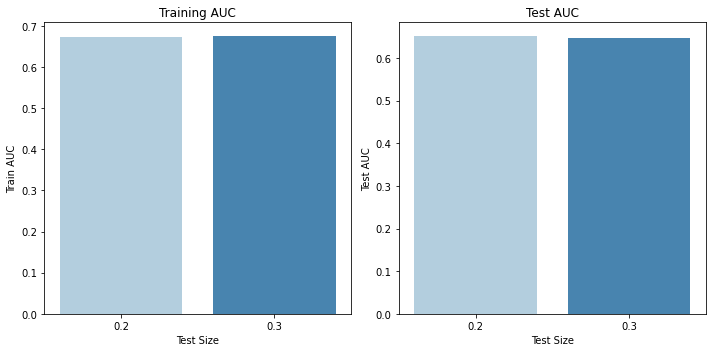

In [14]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes to iterate over
test_sizes = [0.2, 0.3]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    print(f"Test Size: {test_size}")

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Initialise LightGBM classifier model
    model = lgb.LGBMClassifier(random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calculate AUC and accuracy for test and training data
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print metrics for training and test data
    print("Training AUC:", train_auc)
    print("Test AUC:", test_auc)
    print("Training Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("=============================================")

    # Store results in a dictionary
    result = {
        'Test Size': test_size,
        'Train AUC': train_auc,
        'Test AUC': test_auc,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
    }

    results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create bar plots for AUC and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Test Size', y='Train AUC', palette="Blues")
plt.title("Training AUC")

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Test Size', y='Test AUC', palette="Blues")
plt.title("Test AUC")

plt.tight_layout()
plt.show()


#### Cross Validation

Test Size: 0.2, Number of Folds: 5
Average Training AUC: 0.6753859442056462
Average Training Accuracy: 0.8220113663460774
Average Test AUC: 0.6491713374403437
Average Test Accuracy: 0.804244495668071
Test Size: 0.2, Number of Folds: 10
Average Training AUC: 0.6739242125814935
Average Training Accuracy: 0.8213275750911867
Average Test AUC: 0.6500828031087594
Average Test Accuracy: 0.8050631905253954
Test Size: 0.2, Number of Folds: 20
Average Training AUC: 0.6740435857247259
Average Training Accuracy: 0.8211316982503989
Average Test AUC: 0.6497309935497453
Average Test Accuracy: 0.804769115239956
Test Size: 0.3, Number of Folds: 5
Average Training AUC: 0.6767702683434687
Average Training Accuracy: 0.8231123509775976
Average Test AUC: 0.6490261964687852
Average Test Accuracy: 0.8045401516837941
Test Size: 0.3, Number of Folds: 10
Average Training AUC: 0.6757502316790569
Average Training Accuracy: 0.8225052392713262
Average Test AUC: 0.6494936070198785
Average Test Accuracy: 0.80500347677

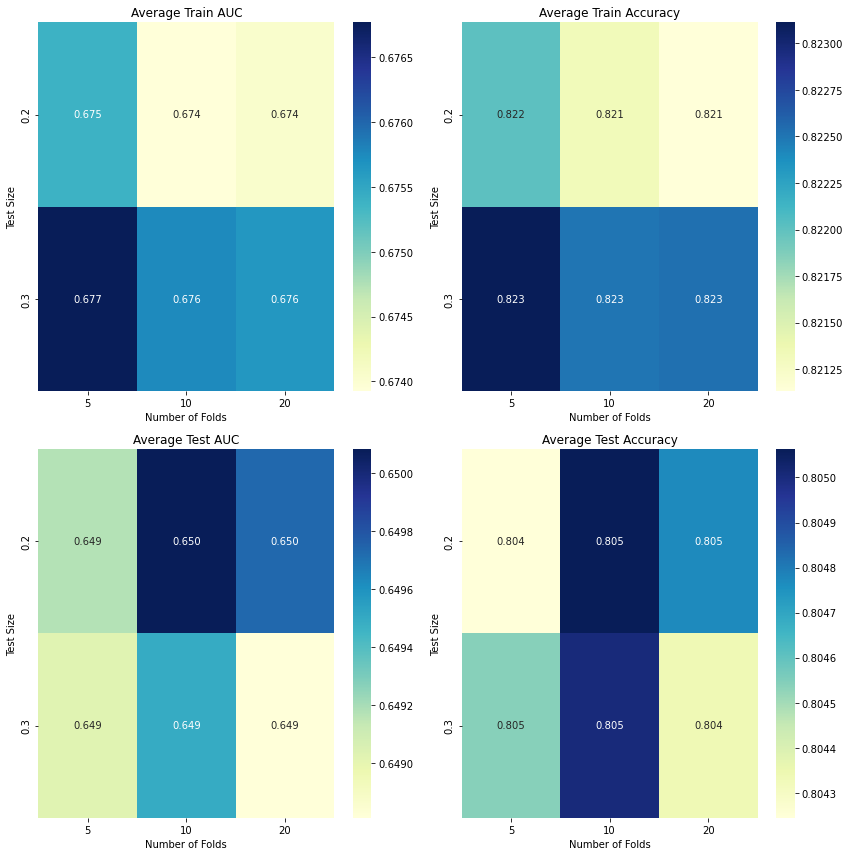

In [17]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes and numbers of folds to iterate over
test_sizes = [0.2, 0.3]
num_folds_list = [5, 10, 20]

# Create empty lists to store results
results = []

for test_size in test_sizes:
    for num_folds in num_folds_list:
        print(f"Test Size: {test_size}, Number of Folds: {num_folds}")

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        # Initialise LightGBM classifier model
        model = lgb.LGBMClassifier(random_state=42)

        # Initialise KFold with current number of folds
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

        # Lists to store evaluation metrics for training and test data
        train_auc_scores = []
        train_accuracy_scores = []
        test_auc_scores = []
        test_accuracy_scores = []

        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X_train):
            X_fold_train, y_fold_train = X_train.iloc[train_index], y_train.iloc[train_index]
            X_fold_test, y_fold_test = X_train.iloc[test_index], y_train.iloc[test_index]

            # Fit the model to the training fold data
            model.fit(X_fold_train, y_fold_train)

            # Predict on the fold test data using the trained model
            y_fold_test_pred = model.predict(X_fold_test)
            y_fold_train_pred = model.predict(X_fold_train)

            train_auc = roc_auc_score(y_fold_train, y_fold_train_pred)
            train_accuracy = accuracy_score(y_fold_train, y_fold_train_pred)
            test_auc = roc_auc_score(y_fold_test, y_fold_test_pred)
            test_accuracy = accuracy_score(y_fold_test, y_fold_test_pred)

            train_auc_scores.append(train_auc)
            train_accuracy_scores.append(train_accuracy)
            test_auc_scores.append(test_auc)
            test_accuracy_scores.append(test_accuracy)

        # Fit the model to the entire training data
        model.fit(X_train, y_train)

        # Evaluate the model on the separate test data
        y_test_pred = model.predict(X_test)
        test_auc = roc_auc_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate average AUC and accuracy across all folds for training and test data
        train_avg_auc = sum(train_auc_scores) / num_folds
        train_avg_accuracy = sum(train_accuracy_scores) / num_folds
        test_avg_auc = sum(test_auc_scores) / num_folds
        test_avg_accuracy = sum(test_accuracy_scores) / num_folds

        # Print average metrics for training and test data
        print("Average Training AUC:", train_avg_auc)
        print("Average Training Accuracy:", train_avg_accuracy)
        print("Average Test AUC:", test_avg_auc)
        print("Average Test Accuracy:", test_avg_accuracy)
        print("=============================================")

        # Store results in a dictionary
        result = {
            'Test Size': test_size,
            'Number of Folds': num_folds,
            'Train AUC': train_avg_auc,
            'Train Accuracy': train_avg_accuracy,
            'Test AUC': test_avg_auc,
            'Test Accuracy': test_avg_accuracy,
        }

        results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create heatmaps for average AUC and accuracy
heatmap_data_train_auc = results_df.pivot("Test Size", "Number of Folds", "Train AUC")
heatmap_data_train_accuracy = results_df.pivot("Test Size", "Number of Folds", "Train Accuracy")
heatmap_data_test_auc = results_df.pivot("Test Size", "Number of Folds", "Test AUC")
heatmap_data_test_accuracy = results_df.pivot("Test Size", "Number of Folds", "Test Accuracy")

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(heatmap_data_train_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train AUC")

plt.subplot(2, 2, 2)
sns.heatmap(heatmap_data_train_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Train Accuracy")

plt.subplot(2, 2, 3)
sns.heatmap(heatmap_data_test_auc, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test AUC")

plt.subplot(2, 2, 4)
sns.heatmap(heatmap_data_test_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Test Accuracy")

plt.tight_layout()
plt.show()


## Neural Network

Loop over epochs

Test Size: 0.2, Epochs: 10
Epoch 1/10
3146/3146 [==============================] - 5s 1ms/step - loss: 0.6826 - accuracy: 0.7433 - val_loss: 0.4639 - val_accuracy: 0.7456
Epoch 2/10
3146/3146 [==============================] - 5s 2ms/step - loss: 0.5643 - accuracy: 0.7572 - val_loss: 0.6645 - val_accuracy: 0.7767
Epoch 3/10
3146/3146 [==============================] - 5s 2ms/step - loss: 0.5249 - accuracy: 0.7606 - val_loss: 0.4498 - val_accuracy: 0.7817
Epoch 4/10
3146/3146 [==============================] - 5s 2ms/step - loss: 0.4885 - accuracy: 0.7654 - val_loss: 0.4489 - val_accuracy: 0.7782
Epoch 5/10
3146/3146 [==============================] - 5s 2ms/step - loss: 0.4702 - accuracy: 0.7702 - val_loss: 0.4366 - val_accuracy: 0.7692
Epoch 6/10
3146/3146 [==============================] - 5s 1ms/step - loss: 0.4529 - accuracy: 0.7744 - val_loss: 0.5432 - val_accuracy: 0.7156
Epoch 7/10
3146/3146 [==============================] - 5s 2ms/step - loss: 0.4451 - accuracy: 0.7769 - val_l

3146/3146 [==============================] - 4s 1ms/step - loss: 0.4270 - accuracy: 0.7900 - val_loss: 0.4250 - val_accuracy: 0.7888
Epoch 26/30
3146/3146 [==============================] - 5s 1ms/step - loss: 0.4272 - accuracy: 0.7890 - val_loss: 0.4243 - val_accuracy: 0.7874
Epoch 27/30
3146/3146 [==============================] - 5s 2ms/step - loss: 0.4266 - accuracy: 0.7895 - val_loss: 0.4274 - val_accuracy: 0.7863
Epoch 28/30
3146/3146 [==============================] - 4s 1ms/step - loss: 0.4264 - accuracy: 0.7896 - val_loss: 0.4348 - val_accuracy: 0.7763
Epoch 29/30
3146/3146 [==============================] - 4s 1ms/step - loss: 0.4264 - accuracy: 0.7906 - val_loss: 0.4241 - val_accuracy: 0.7871
Epoch 30/30
3146/3146 [==============================] - 4s 1ms/step - loss: 0.4265 - accuracy: 0.7899 - val_loss: 0.4265 - val_accuracy: 0.7857
Test Loss: 0.42462578415870667
Test Accuracy: 0.7883190512657166
Test Size: 0.3, Epochs: 10
Epoch 1/10
2753/2753 [============================

Epoch 19/30
2753/2753 [==============================] - 4s 1ms/step - loss: 0.4272 - accuracy: 0.7901 - val_loss: 0.4256 - val_accuracy: 0.7872
Epoch 20/30
2753/2753 [==============================] - 4s 1ms/step - loss: 0.4269 - accuracy: 0.7906 - val_loss: 0.4263 - val_accuracy: 0.7842
Epoch 21/30
2753/2753 [==============================] - 4s 1ms/step - loss: 0.4268 - accuracy: 0.7908 - val_loss: 0.4296 - val_accuracy: 0.7873
Epoch 22/30
2753/2753 [==============================] - 4s 1ms/step - loss: 0.4270 - accuracy: 0.7899 - val_loss: 0.4266 - val_accuracy: 0.7857
Epoch 23/30
2753/2753 [==============================] - 4s 1ms/step - loss: 0.4266 - accuracy: 0.7905 - val_loss: 0.4254 - val_accuracy: 0.7852
Epoch 24/30
2753/2753 [==============================] - 4s 1ms/step - loss: 0.4264 - accuracy: 0.7911 - val_loss: 0.4289 - val_accuracy: 0.7853
Epoch 25/30
2753/2753 [==============================] - 4s 2ms/step - loss: 0.4265 - accuracy: 0.7915 - val_loss: 0.4259 - val_ac

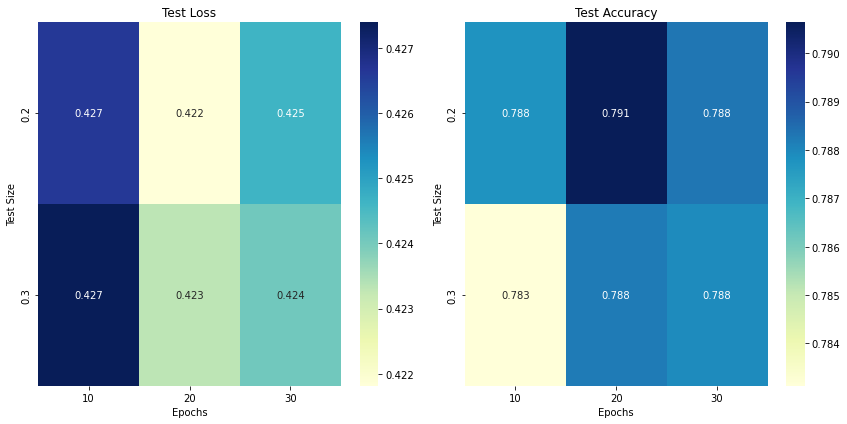

In [10]:
# Assigning 'PolicyIssued' as target variable and the rest as features
X = df.drop('PolicyIssued', axis=1)
y = df['PolicyIssued']

# List of test sizes and epochs to iterate over
test_sizes = [0.2, 0.3]
epochs_list = [10, 20, 30]  # Add the epoch values you want to iterate over

# Create empty lists to store results
results = []

for test_size in test_sizes:
    for epochs in epochs_list:
        print(f"Test Size: {test_size}, Epochs: {epochs}")

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        # Initialise a neural network model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, validation_split=0.2)

        # Evaluate the model on the separate test data
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

        # Print metrics for test data
        print("Test Loss:", test_loss)
        print("Test Accuracy:", test_accuracy)
        print("=============================================")

        # Store results in a dictionary
        result = {
            'Test Size': test_size,
            'Epochs': epochs,
            'Test Loss': test_loss,
            'Test Accuracy': test_accuracy
        }

        results.append(result)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)

# Create heatmaps for test loss and accuracy
heatmap_data_test_loss = results_df.pivot("Test Size", "Epochs", "Test Loss")
heatmap_data_test_accuracy = results_df.pivot("Test Size", "Epochs", "Test Accuracy")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(heatmap_data_test_loss, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Test Loss")

plt.subplot(1, 2, 2)
sns.heatmap(heatmap_data_test_accuracy, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Test Accuracy")

plt.tight_layout()
plt.show()
